In [0]:
import torch, torchvision
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from matplotlib import pyplot as plt

https://github.com/pytorch/examples/blob/master/mnist/main.py

In [0]:
train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('./data', train=True, download=True,
                       transform=torchvision.transforms.Compose([
                           #torchvision.transforms.RandomRotation(40),
                           #torchvision.transforms.RandomAffine([-90, 90], translate=[0.2, 0.2], scale=[0.5, 0.5], shear=[-10, 10]),
                           torchvision.transforms.ToTensor(),
                           torchvision.transforms.Normalize((0.1307,), (0.3081,)),
                           
                       ])),
        batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('./data', train=False, transform=torchvision.transforms.Compose([
                           torchvision.transforms.ToTensor(),
                           torchvision.transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=1000, shuffle=True)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


net = Net()

In [0]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    log_interval = 10
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.4f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [16]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

for epoch in range(1, 10 + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.307946
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.258004
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.202584
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.118908
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.001953
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.818075
Train Epoch: 1 [3840/60000 (6%)]	Loss: 1.474658
Train Epoch: 1 [4480/60000 (7%)]	Loss: 1.218965
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.791671
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.543299
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.515555
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.497075
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.433863
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.410888
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.370272
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.537274
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.396238
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.237942
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.238116
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.373396
Train Epoch: 1 [12800/60000 (

In [0]:
torch.save(model.state_dict(),"mnist_cnn.pt")

In [0]:
def see(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            matches = pred.eq(target.view_as(pred)).cpu().numpy().flatten()
            pred = pred.cpu().numpy().flatten()[matches == 0]
            target = target.cpu().numpy().flatten()[matches == 0]
            print("pred", pred.shape)
            print("target", target.shape)
            print("matches", matches.shape, (matches == 0).shape)
            imgs = data.cpu().numpy()[:, 0, :, :][matches == 0]
            print("mismatches", (matches == 0).sum())
            for i, img in enumerate(imgs):
              print(i, "prediction", pred[i], "target", target[i])
              plt.imshow(img)
              plt.show()
            break
            
            #test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            #pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            #correct += pred.eq(target.view_as(pred)).sum().item()



Test set: Average loss: 0.0298, Accuracy: 9902/10000 (99.0200%)

pred (8,)
target (8,)
matches (1000,) (1000,)
mismatches 8
0 prediction 3 target 5


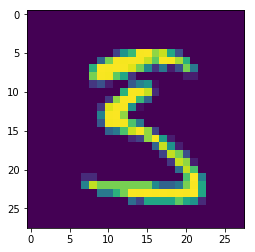

1 prediction 9 target 4


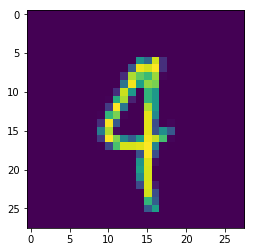

2 prediction 3 target 7


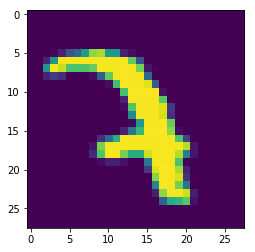

3 prediction 7 target 2


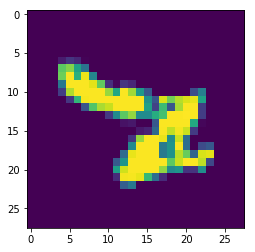

4 prediction 3 target 2


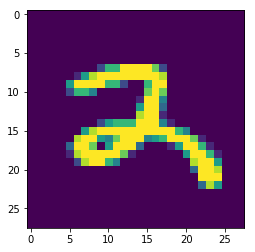

5 prediction 3 target 5


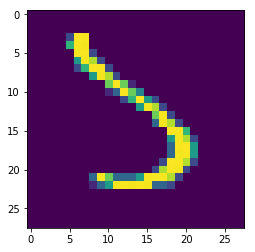

6 prediction 8 target 5


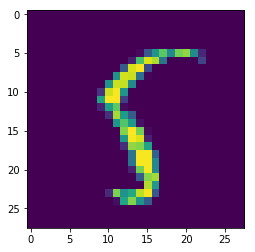

7 prediction 2 target 7


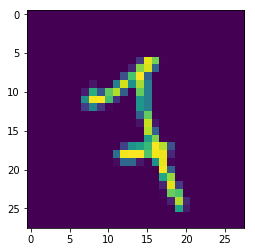

In [19]:
test(model, device, test_loader)
see(model, device, test_loader)